In [26]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Bibliotek importerade!")

conn = sqlite3.connect('gronagarden_pipeline.db')

query = "SELECT * FROM orders_clean"
df = pd.read_sql(query, conn)

conn.close()

print(f"Data inläst! Antal rader: {len(df)}")
print(f"Kolumner: {df.columns.tolist()}")
df.head()

Bibliotek importerade!
Data inläst! Antal rader: 2277
Kolumner: ['order_id', 'orderrad_id', 'produkt_id', 'kund_id', 'orderdatum_clean', 'wanted_leveransdatum_clean', 'faktiskt_leveransdatum_clean', 'produktnamn_clean', 'season_clean', 'kategori', 'antal_clean', 'pris_clean', 'vikt_gram_clean', 'leveranszon_clean', 'betyg', 'sentiment', 'sentiment_score', 'recension_clean', 'recensionsdatum_clean', 'is_suspect']


,order_id,orderrad_id,produkt_id,kund_id,orderdatum_clean,wanted_leveransdatum_clean,faktiskt_leveransdatum_clean,produktnamn_clean,season_clean,kategori,antal_clean,pris_clean,vikt_gram_clean,leveranszon_clean,betyg,sentiment,sentiment_score,recension_clean,recensionsdatum_clean,is_suspect
0,GG-2024-00001,GG-2024-00001-1,PLT-INO-003,KUND-10912,2024-01-01,2024-01-05,2024-01-05,gullranka,alla,Inomhusväxter,2,129.0,500.0,Zon 3,3.0,positive,0.454180,"Varken bra eller dåligt, gör jobbet.",2024-01-10,0
1,GG-2024-00002,GG-2024-00002-1,FRO-TOM-001,KUND-14597,2024-01-07,2024-01-12,2024-01-12,tomatfrön,vår,Frön,3,49.0,5.0,Zon 3,2.0,negative,0.475422,Paketet såg ut att ha kastats från lastbilen.,2024-01-19,0
2,GG-2024-00002,GG-2024-00002-2,PLT-INO-001,KUND-14597,2024-01-07,2024-01-12,2024-01-12,monstera deliciosa,alla,Inomhusväxter,3,299.0,2000.0,Zon 3,3.0,neutral,0.648327,"Helt okej, men hittade billigare i lokal butik.",2024-02-11,0
3,GG-2024-00003,GG-2024-00003-1,FRO-ORT-001,KUND-14392,2024-01-04,2024-01-13,2024-01-03,örtfrön mix,vår,Frön,2,59.0,15.0,Zon 5,4.0,positive,0.867196,"Min monstera är fantastisk, så stor och fin!",2024-01-25,0
4,GG-2024-00003,GG-2024-00003-2,PLT-INO-003,KUND-14392,2024-01-04,2024-01-13,2024-01-13,gullranka,alla,Inomhusväxter,1,129.0,500.0,Zon 5,5.0,positive,0.838423,Bästa fröerna jag testat. Hög grobarhet.,2024-01-30,0


In [27]:
df['orderdatum_clean'] = pd.to_datetime(df['orderdatum_clean'])
df['wanted_leveransdatum_clean'] = pd.to_datetime(df['wanted_leveransdatum_clean'])
df['faktiskt_leveransdatum_clean'] = pd.to_datetime(df['faktiskt_leveransdatum_clean'])

df['year'] = df['orderdatum_clean'].dt.year
df['month'] = df['orderdatum_clean'].dt.month
df['month_name'] = df['orderdatum_clean'].dt.month_name() 
df['week'] = df['orderdatum_clean'].dt.isocalendar().week
df['weekday'] = df['orderdatum_clean'].dt.day_name() 
df['weekday_number'] = df['orderdatum_clean'].dt.dayofweek 
df['day_of_month'] = df['orderdatum_clean'].dt.day
df['year_month'] = df['orderdatum_clean'].dt.to_period('M') 
df['quarter'] = df['orderdatum_clean'].dt.quarter

print("Datetime features skapade:")
print(f"   - Year, Month, Month_name, Week, Weekday, Quarter")

df['total_price'] = df['antal_clean'] * df['pris_clean'] 
df['total_weight'] = df['antal_clean'] * df['vikt_gram_clean'] 

print("Ekonomiska features skapade:")
print(df[['total_price', 'total_weight']].head())

Datetime features skapade:
   - Year, Month, Month_name, Week, Weekday, Quarter
Ekonomiska features skapade:
   total_price  total_weight
0        258.0        1000.0
1        147.0          15.0
2        897.0        6000.0
3        118.0          30.0
4        129.0         500.0


In [28]:
df['wanted_leveransdatum_days'] = (df['wanted_leveransdatum_clean'] - df['orderdatum_clean']).dt.days
df['actual_leveransdatum_days'] = (df['faktiskt_leveransdatum_clean'] - df['orderdatum_clean']).dt.days
df['leveransdatum_skillnad'] = (df['faktiskt_leveransdatum_clean'] - df['wanted_leveransdatum_clean']).dt.days

df['leveransdatum_category'] = pd.cut(df['actual_leveransdatum_days'], 
                                bins=[-float('inf'), 3, 7, 14, float('inf')],
                                labels=['Fast (<3 days)', 
                                       'Normal (3-7 days)', 
                                       'Slow (7-14 days)', 
                                       'Very slow (>14 days)'])

print("Leverans-features skapade:")
print(df[['wanted_leveransdatum_days', 'actual_leveransdatum_days', 'leveransdatum_skillnad', 'leveransdatum_category']].head(10))

Leverans-features skapade:
   wanted_leveransdatum_days  actual_leveransdatum_days  \
0                        4.0                        4.0   
1                        5.0                        5.0   
2                        5.0                        5.0   
3                        9.0                       -1.0   
4                        9.0                        9.0   
5                        NaN                        2.0   
6                        2.0                        2.0   
7                        NaN                        2.0   
8                        2.0                        2.0   
9                        3.0                        NaN   

   leveransdatum_skillnad leveransdatum_category  
0                     0.0      Normal (3-7 days)  
1                     0.0      Normal (3-7 days)  
2                     0.0      Normal (3-7 days)  
3                   -10.0         Fast (<3 days)  
4                     0.0       Slow (7-14 days)  
5                

In [29]:
df['price_class'] = pd.cut(df['pris_clean'], 
                         bins=[0, 100, 300, 1000, float('inf')],
                         labels=['Cheap (<100kr)', 
                                'Medium (100-300kr)', 
                                'Expensive (300-1000kr)', 
                                'Premium (>1000kr)'])

df['rating_category'] = pd.cut(df['betyg'], 
                              bins=[0, 2, 3, 4, 5],
                              labels=['Bad (1-2)', 
                                     'Okay (3)', 
                                     'Good (4)', 
                                     'Excellent (5)'])

print("Kategoriserings-features skapade:")
print(df[['price_class', 'rating_category']].head(10))

Kategoriserings-features skapade:
          price_class rating_category
0  Medium (100-300kr)        Okay (3)
1      Cheap (<100kr)       Bad (1-2)
2  Medium (100-300kr)        Okay (3)
3      Cheap (<100kr)        Good (4)
4  Medium (100-300kr)   Excellent (5)
5      Cheap (<100kr)             NaN
6  Medium (100-300kr)             NaN
7  Medium (100-300kr)   Excellent (5)
8  Medium (100-300kr)   Excellent (5)
9      Cheap (<100kr)        Okay (3)


In [30]:
df_encoded = pd.get_dummies(df, columns=['quarter'], prefix='quarter')

new_quarter_columns = [col for col in df_encoded.columns if col.startswith('quarter_')]

print("One-hot encoding för quarter:")
print(f"Skapade kolumner: {new_quarter_columns}")
print("\nExempel på resultatet (första 10 raderna):")
print(df_encoded[['quarter'] + new_quarter_columns].head(10) if 'quarter' in df_encoded.columns else df_encoded[new_quarter_columns].head(10))

print("\nFördelning av quarter-värden:")
for col in new_quarter_columns:
    count = df_encoded[col].sum()
    print(f"   {col}: {count} rader")

df = df_encoded

print("\n" + "="*60)
print("FEATURE ENGINEERING KLART!")
print("="*60)
print(f"Totalt antal kolumner nu: {len(df.columns)}")
print(f"Nya features skapade: {len(df.columns) - 19}")

One-hot encoding för quarter:
Skapade kolumner: ['quarter_1', 'quarter_2', 'quarter_3', 'quarter_4']

Exempel på resultatet (första 10 raderna):
   quarter_1  quarter_2  quarter_3  quarter_4
0       True      False      False      False
1       True      False      False      False
2       True      False      False      False
3       True      False      False      False
4       True      False      False      False
5       True      False      False      False
6       True      False      False      False
7       True      False      False      False
8       True      False      False      False
9       True      False      False      False

Fördelning av quarter-värden:
   quarter_1: 335 rader
   quarter_2: 1209 rader
   quarter_3: 434 rader
   quarter_4: 299 rader

FEATURE ENGINEERING KLART!
Totalt antal kolumner nu: 40
Nya features skapade: 21


In [32]:
print("\nExempel på nya features:")
print("\nDatetime features:")
print(df[['orderdatum_clean', 'year', 'month_name', 'week', 'weekday']].head(3))

print("\nEkonomiska features:")
print(df[['produktnamn_clean', 'antal_clean', 'pris_clean', 'total_price']].head(3))

print("\nLeverans features:")
print(df[['order_id', 'wanted_leveransdatum_days', 'actual_leveransdatum_days', 'leveransdatum_skillnad', 'leveransdatum_category']].head(3))

print("\nKategoriserings-features:")
print(df[['produktnamn_clean', 'pris_clean', 'price_class', 'betyg', 'rating_category']].head(3))


Exempel på nya features:

Datetime features:
  orderdatum_clean  year month_name  week weekday
0       2024-01-01  2024    January     1  Monday
1       2024-01-07  2024    January     1  Sunday
2       2024-01-07  2024    January     1  Sunday

Ekonomiska features:
    produktnamn_clean  antal_clean  pris_clean  total_price
0           gullranka            2       129.0        258.0
1           tomatfrön            3        49.0        147.0
2  monstera deliciosa            3       299.0        897.0

Leverans features:
        order_id  wanted_leveransdatum_days  actual_leveransdatum_days  \
0  GG-2024-00001                        4.0                        4.0   
1  GG-2024-00002                        5.0                        5.0   
2  GG-2024-00002                        5.0                        5.0   

   leveransdatum_skillnad leveransdatum_category  
0                     0.0      Normal (3-7 days)  
1                     0.0      Normal (3-7 days)  
2                     

Försäljning per månad:
        Month  Total_sales
0     January      14051.0
1    February       9835.0
2       March      65892.0
3       April     114775.0
4         May     174974.0
5        June      36723.0
6        July      24365.0
7      August      74240.0
8   September      93440.0
9     October      34435.0
10   November      40139.0
11   December      30522.0


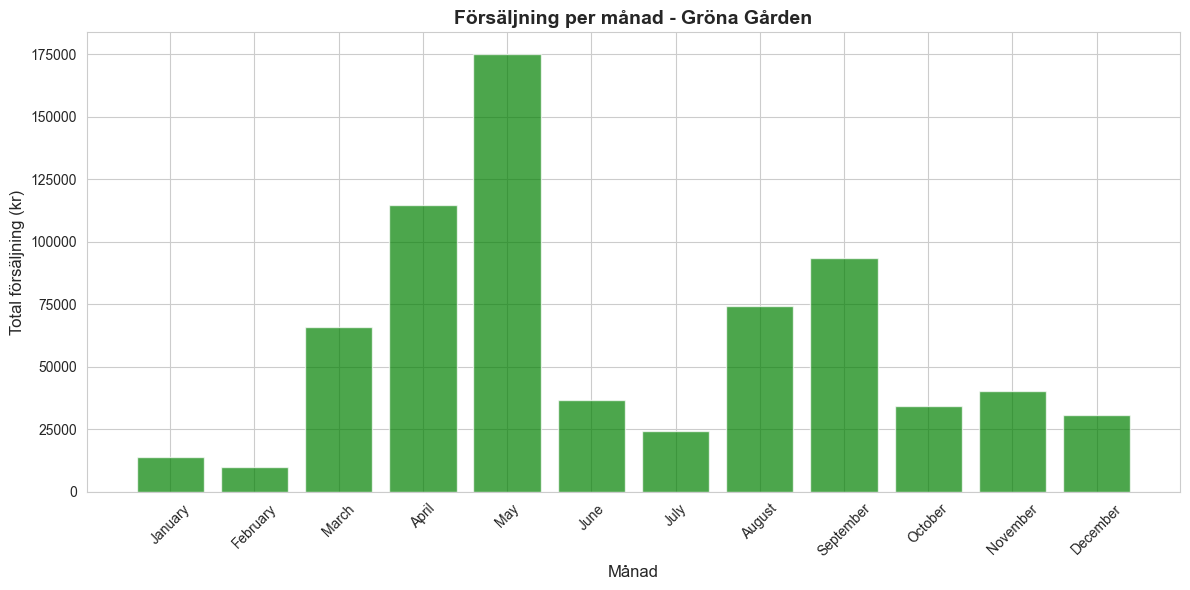

In [33]:
sales_per_month = df.groupby(['month', 'month_name'])['total_price'].sum().reset_index()
sales_per_month = sales_per_month.sort_values('month') 
sales_per_month.columns = ['Month_number', 'Month', 'Total_sales']

print("Försäljning per månad:")
print(sales_per_month[['Month', 'Total_sales']])

plt.figure(figsize=(12, 6))
plt.bar(sales_per_month['Month'], 
        sales_per_month['Total_sales'], 
        color='green', 
        alpha=0.7)
plt.xlabel('Månad', fontsize=12)
plt.ylabel('Total försäljning (kr)', fontsize=12)
plt.title('Försäljning per månad - Gröna Gården', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

📊 Försäljning per vecka (visar första 10):
   Year  Week  Total_sales
0  2024     1       4398.0
1  2024     2       3208.0
2  2024     3       1718.0
3  2024     4       4727.0
4  2024     5       1608.0
5  2024     6       2573.0
6  2024     7       2428.0
7  2024     8       1994.0
8  2024     9      12906.0
9  2024    10       7273.0


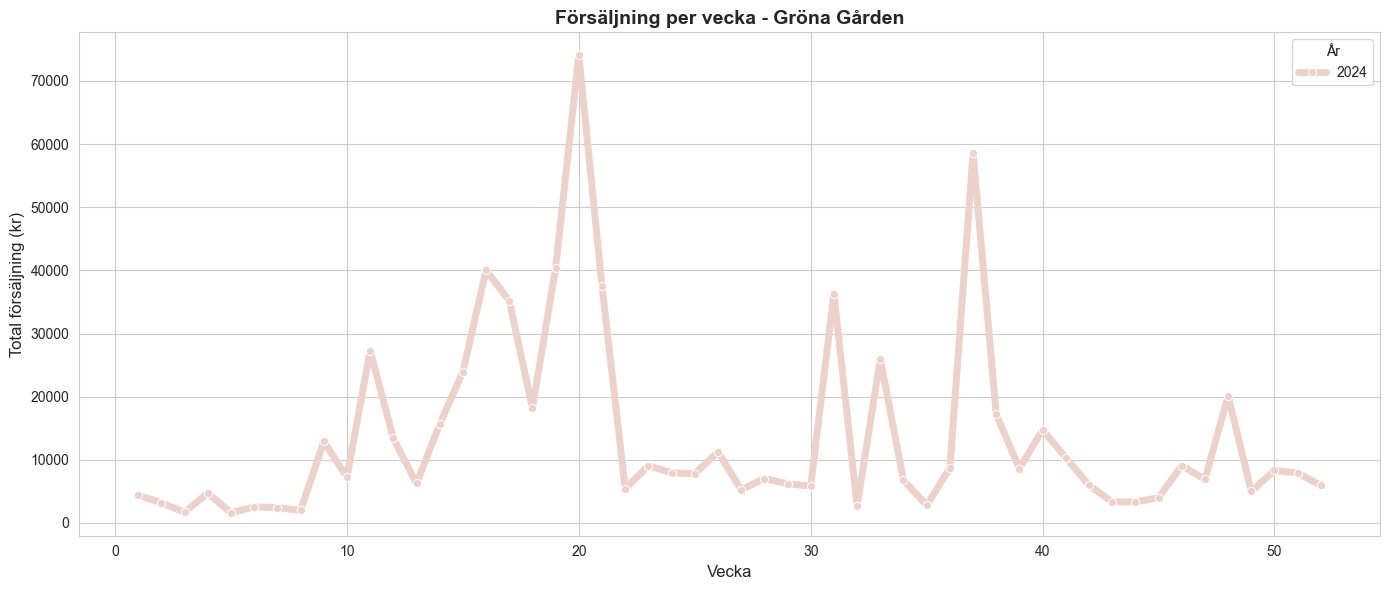

In [35]:
sales_per_week = df.groupby(['year', 'week'])['total_price'].sum().reset_index()
sales_per_week = sales_per_week.sort_values(['year', 'week'])
sales_per_week.columns = ['Year', 'Week', 'Total_sales']

print("📊 Försäljning per vecka (visar första 10):")
print(sales_per_week.head(10))

plt.figure(figsize=(14, 6))
sns.lineplot(data=sales_per_week, 
             x='Week', 
             y='Total_sales', 
             hue='Year',  
             marker='o', 
             linewidth=5)
plt.xlabel('Vecka', fontsize=12)
plt.ylabel('Total försäljning (kr)', fontsize=12)
plt.title('Försäljning per vecka - Gröna Gården', fontsize=14, fontweight='bold')
plt.legend(title='År')
plt.tight_layout()
plt.show()

Genomsnittligt ordervärde: 671.11 kr

Fördelning av orderstorlekar:
order_size
Small orders (<500kr)         702
Medium orders (500-1500kr)    328
Large orders (>1500kr)         33
Name: count, dtype: int64


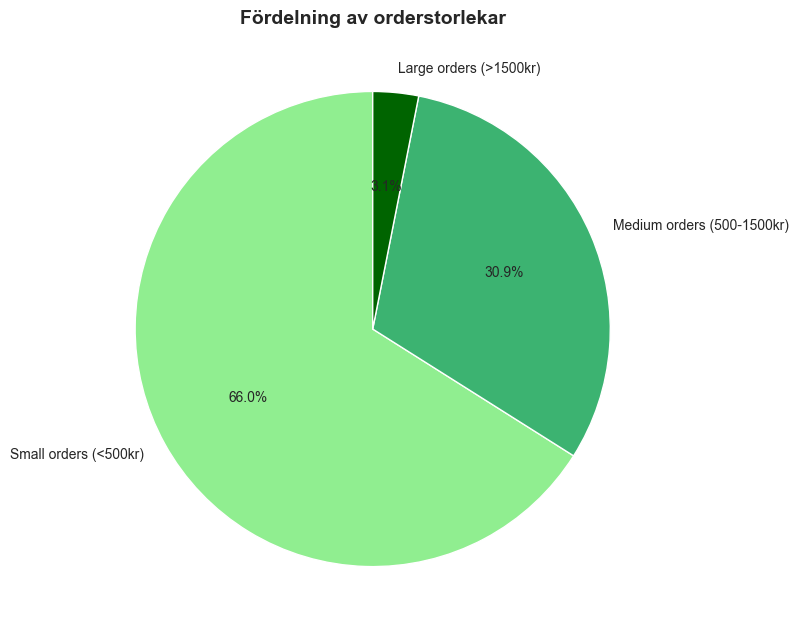

In [36]:
order_value = df.groupby('order_id')['total_price'].sum()

average_order_value = order_value.mean()

print(f"Genomsnittligt ordervärde: {average_order_value:.2f} kr")

df_order = df.groupby('order_id')['total_price'].sum().reset_index()
df_order.columns = ['order_id', 'order_value']

df_order['order_size'] = pd.cut(df_order['order_value'], 
                                   bins=[0, 500, 1500, float('inf')],
                                   labels=['Small orders (<500kr)', 
                                          'Medium orders (500-1500kr)', 
                                          'Large orders (>1500kr)'])

order_size_distribution = df_order['order_size'].value_counts()

print("\nFördelning av orderstorlekar:")
print(order_size_distribution)

plt.figure(figsize=(8, 8))
plt.pie(order_size_distribution, 
        labels=order_size_distribution.index, 
        autopct='%1.1f%%',  
        colors=['lightgreen', 'mediumseagreen', 'darkgreen'],
        startangle=90)
plt.title('Fördelning av orderstorlekar', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

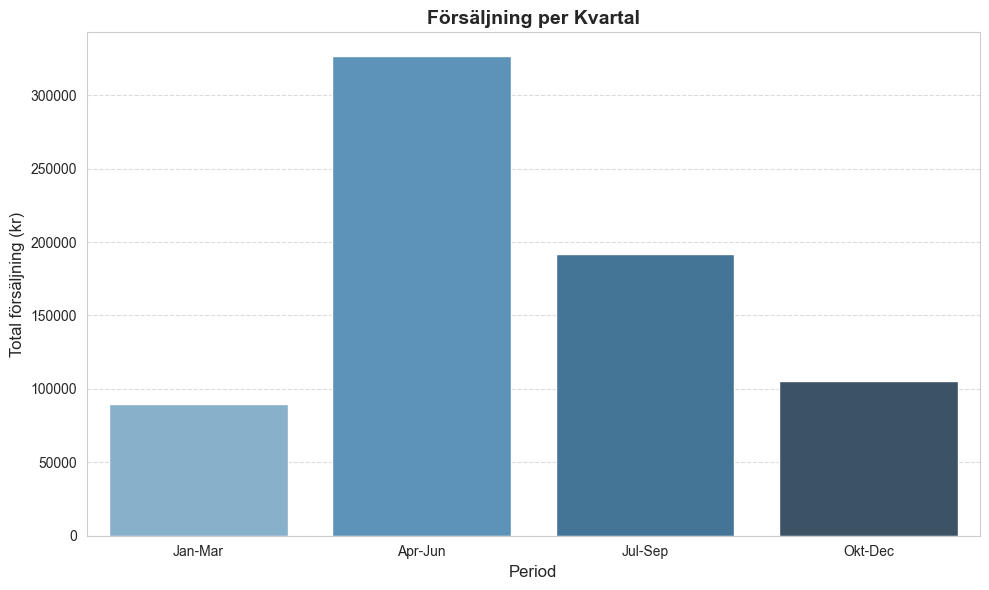

Kvartalsrapport:
   Jan-Mar: 89 778 kr
   Apr-Jun: 326 472 kr
   Jul-Sep: 192 045 kr
   Okt-Dec: 105 096 kr


In [43]:
quarter_columns = [col for col in df.columns if col.startswith('quarter_')]

if quarter_columns:
    temp_quarters = df[quarter_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
    
    quarter_map = {
        '1': 'Jan-Mar',
        '2': 'Apr-Jun',
        '3': 'Jul-Sep',
        '4': 'Okt-Dec'
    }
    
    df['quarter_label'] = temp_quarters.idxmax(axis=1).str.replace('quarter_', '').map(quarter_map)
    
    sales_quarter = df.groupby('quarter_label')['total_price'].sum().reset_index()
    
    sort_order = ['Jan-Mar', 'Apr-Jun', 'Jul-Sep', 'Okt-Dec']
    sales_quarter['quarter_label'] = pd.Categorical(sales_quarter['quarter_label'], categories=sort_order, ordered=True)
    sales_quarter = sales_quarter.sort_values('quarter_label')

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=sales_quarter, 
        x='quarter_label', 
        y='total_price', 
        hue='quarter_label', 
        palette='Blues_d', 
        legend=False
    )
    
    plt.title('Försäljning per Kvartal', fontsize=14, fontweight='bold')
    plt.ylabel('Total försäljning (kr)', fontsize=12)
    plt.xlabel('Period', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("Kvartalsrapport:")
    for _, row in sales_quarter.iterrows():
        print(f"   {row['quarter_label']}: {row['total_price']:,.0f} kr".replace(',', ' '))
else:
    print("Inga 'quarter_'-kolumner hittades.")

In [46]:
print("=" * 60)
print("SAMMANFATTNING - KPI:ER FÖR GRÖNA GÅRDEN")
print("=" * 60)
print(f"\nGenomsnittligt ordervärde: {average_order_value:.2f} kr")
print(f"\nTotal försäljning alla månader: {df['total_price'].sum():.2f} kr")
print(f"\nBästa säsong: {sales_quarter.iloc[0]['quarter_label']} "
      f"({sales_quarter.iloc[0]['total_price']:.2f} kr)")
print(f"\nAntal unika order: {df['order_id'].nunique()}")
print(f"\nAntal produkter sålda: {df['antal_clean'].sum()}")
print(f"\nGenomsnittlig leveranstid: {df['actual_leveransdatum_days'].mean():.1f} dagar")
print("=" * 60)

SAMMANFATTNING - KPI:ER FÖR GRÖNA GÅRDEN

Genomsnittligt ordervärde: 671.11 kr

Total försäljning alla månader: 713391.00 kr

Bästa säsong: Jan-Mar (89778.00 kr)

Antal unika order: 1063

Antal produkter sålda: 4250

Genomsnittlig leveranstid: 4.9 dagar


In [47]:
print("-" * 60)
print("TOLKNING AV RESULTATEN")
print("-" * 60)

print("\nFörsäljning per månad/period:")
print("   * Identifierar trender, högsäsong och lågsäsong över tid.")
print("   * Underlag för resursplanering avseende lager och bemanning.")

print("\nGenomsnittligt ordervärde:")
print("   * Indikerar kundens genomsnittliga köpkraft per besök.")
print("   * Strategi vid lågt värde: Paketera komplementvaror (t.ex. jord + gödsel).")
print("   * Strategi vid högt värde: Analysera framgångsfaktorer för att bibehålla nivån.")

print("\nKvartals- och säsongsmönster:")
print("   * Fastställer vilka tidsperioder som driver störst omsättning.")
print("   * Optimerar inköp av färskvaror och växter baserat på historisk efterfrågan.")
print("   * Styr inriktningen på marknadsföringskampanjer.")

print("\nOrderstorlekar:")
print("   * Visar fördelningen mellan små och stora köp.")
print("   * Små ordrar: Möjlighet att införa minimigräns eller justera fraktvillkor.")
print("   * Stora ordrar: Möjlighet att premiera lojalitet genom volymrabatter.")

print("\nVeckodag-analys:")
print("   * Kartlägger kundflödet under veckans dagar.")
print("   * Används för att schemalägga personal och kampanjstarter.")
print("   * Möjliggör riktade specialerbjudanden under dagar med lägre aktivitet.")

print("-" * 60)

------------------------------------------------------------
TOLKNING AV RESULTATEN
------------------------------------------------------------

Försäljning per månad/period:
   * Identifierar trender, högsäsong och lågsäsong över tid.
   * Underlag för resursplanering avseende lager och bemanning.

Genomsnittligt ordervärde:
   * Indikerar kundens genomsnittliga köpkraft per besök.
   * Strategi vid lågt värde: Paketera komplementvaror (t.ex. jord + gödsel).
   * Strategi vid högt värde: Analysera framgångsfaktorer för att bibehålla nivån.

Kvartals- och säsongsmönster:
   * Fastställer vilka tidsperioder som driver störst omsättning.
   * Optimerar inköp av färskvaror och växter baserat på historisk efterfrågan.
   * Styr inriktningen på marknadsföringskampanjer.

Orderstorlekar:
   * Visar fördelningen mellan små och stora köp.
   * Små ordrar: Möjlighet att införa minimigräns eller justera fraktvillkor.
   * Stora ordrar: Möjlighet att premiera lojalitet genom volymrabatter.

Veck

VISUALISERINGSVAL OCH MOTIVERING

I mitt projekt har jag använt både Matplotlib och Seaborn för att skapa
visualiseringar, eftersom de har olika styrkor och passar olika typer av grafer.

Matplotlib = Bra för enkel kontroll och grundläggande grafer
Seaborn = Bra för mer komplexa visualiseringar med flera kategorier

Genom att kombinera båda får jag det bästa från två världar: enkelhet när
jag behöver det (Matplotlib) och kraftfulla automatiska funktioner för
mer avancerade analyser (Seaborn).